# Metrics

> 

Start with a brief description of the technical component, and an overview that links to the main symbols in the page (you might want to use doclinks)

In [2]:
#| default_exp metrics

In [3]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [4]:
import warnings
warnings.filterwarnings?

Signature:
warnings.filterwarnings(
    action,
    message='',
    category=<class 'Warning'>,
    module='',
    lineno=0,
    append=False,
)
Docstring:
Insert an entry into the list of warnings filters (at the front).

'action' -- one of "error", "ignore", "always", "default", "module",
            or "once"
'message' -- a regex that the warning message must match
'category' -- a class that the warning must be a subclass of
'module' -- a regex that the module name must match
'lineno' -- an integer line number, 0 matches all warnings
'append' -- if true, append to the list of filters
File:      ~/program_files/managers/conda/envs/yuequ/lib/python3.10/warnings.py
Type:      function

In [5]:
#| export
from namable_classify.infra import default_on_exception, ensure_array
import torch.nn.functional as F
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, top_k_accuracy_score, matthews_corrcoef, f1_score, precision_score, recall_score, log_loss, balanced_accuracy_score, cohen_kappa_score, hinge_loss, accuracy_score

from namable_classify.infra import MuteWarnings
import warnings
except_roc_auc_score = default_on_exception(default_value=-1)(roc_auc_score)

def compute_classification_metrics(
    y_true: np.ndarray,  # 1d array-like, or label indicator array / sparse matrix
    y_pred_logits: np.ndarray = None,  # label indicator array / sparse matrix
    logits_to_prob: bool = False,  # function to convert logits to probabilities
    y_pred: np.ndarray = None,  # predicted labels, if None, will be computed from logits
    labels:list[int|str]|None = None,  # list of labels
    supress_warnings: bool = True,  # whether to suppress warnings
    y_pred_metrics_only: bool = False,  # whether to compute only y_pred related metrics
):
        
    if supress_warnings:
        mute = MuteWarnings()
        mute.mute()
    if y_pred_logits is None:
        assert y_pred_metrics_only == True, "y_pred_logits is None, we can only compute y_pred related metrics! "
        assert y_pred is not None, "y_pred_logits is None, y_pred should be specified! "
        # warnings.warn("y_pred_logits is None, will compute y_pred related metrics only! ")
    y_true = ensure_array(y_true)
    if not y_pred_metrics_only:
        y_pred_logits = ensure_array(y_pred_logits)
        # print(type(y_pred_logits)) # <class 'numpy.ndarray'>
        # y_pred_probs = softmax(y_pred_logits)# label indicator array / sparse matrix
        y_pred_probs = (
            np.array(F.softmax(torch.Tensor(y_pred_logits), dim=1))
            if logits_to_prob
            else y_pred_logits
        )  # label indicator array / sparse matrix
    other_res = {}
    if y_pred is None:
        # 必然有 y_pred_logits
        assert y_pred_logits is not None, "y_pred_logits is None, cannot derive y_pred! "
        y_pred = np.argmax(y_pred_logits, axis=1)
    else:
        # 额外计算一个acc
        if not y_pred_metrics_only:
            warnings.warn("y_pred is specified since it may be different from argmax(y_pred_logits), this may happen to prob SVM. ")
        other_res["acc1_pred"] = accuracy_score(y_true, y_pred)
        
        
    # target_names = labels # dataset['train'].features[label_column_name].names
    # report_dict = classification_report(y_true, y_pred_probs, target_names=target_names, output_dict=True)
    
    if not y_pred_metrics_only:
        top_k_res = {
            f"acc{k}": top_k_accuracy_score(y_true, y_pred_probs, k=k, labels=labels)
            for k in [1, 2, 3, 5, 10, 20]
        }
        prob_res = dict(
            # roc_auc=roc_auc_score(
            roc_auc=except_roc_auc_score(
                y_true, y_pred_probs, average="macro", multi_class="ovr", labels=labels
            ),  # ovr更难一些，会不平衡
            hinge_loss=hinge_loss(y_true, y_pred_probs, labels=labels),
            log_loss=log_loss(
                y_true,
                y_pred_probs,
                labels=labels
                ),
            )
    else: 
        top_k_res = {}
        prob_res = {}

    pred_res = dict(
        matthews_corrcoef=matthews_corrcoef(y_true, y_pred),
        f1=f1_score(y_true, y_pred, average="macro", labels=labels),
        precision=precision_score(y_true, y_pred, average="macro", labels=labels),
        recall=recall_score(y_true, y_pred, average="macro", labels=labels),
        balanced_accuracy=balanced_accuracy_score(y_true, y_pred),
        cohen_kappa=cohen_kappa_score(y_true, y_pred, labels=labels),
    )
    if supress_warnings:
        mute.resume()
    
    # return top_k_res| balance_res| report_dict
    return top_k_res | pred_res | prob_res | other_res

In [6]:
compute_classification_metrics(torch.randint(0, 20, size=(100,)), 
                               torch.softmax(torch.randn(100, 20), dim=1), 
                               logits_to_prob=False, 
                               labels=list(range(20)), 
                               )


{
    'acc1': 0.02,
    'acc2': 0.06,
    'acc3': 0.12,
    'acc5': 0.24,
    'acc10': 0.47,
    'acc20': 1.0,
    'matthews_corrcoef': -0.029249687981809908,
    'f1': 0.017424242424242425,
    'precision': 0.015476190476190477,
    'recall': 0.02,
    'balanced_accuracy': 0.02,
    'cohen_kappa': -0.028979420411591628,
    'roc_auc': 0.46511878670112183,
    'hinge_loss': 1.1702374,
    'log_loss': 3.5816344923884653
}

In [19]:
#| export
import numpy as np
from sklearn.metrics import accuracy_score

def per_class_accuracy(y_true, y_pred, labels=None):
    # 如果未提供 labels，则从 y_true 中获取
    if labels is None:
        labels = np.unique(y_true)
    
    # 计算每个类别的准确率
    per_class_acc = {}
    for cls in labels:
        idx = y_true == cls
        acc = accuracy_score(y_true[idx], y_pred[idx])
        per_class_acc[cls] = acc
    
    return per_class_acc
def get_top_bottom_k_classes(per_class_acc, k):
    # 将字典按准确率排序（从高到低）
    sorted_acc = sorted(per_class_acc.items(), key=lambda item: item[1], reverse=True)
    
    # 获取准确率最高的前 k 个类别
    top_k = sorted_acc[:k]
    
    # 获取准确率最低的前 k 个类别
    bottom_k = sorted_acc[-k:]
    
    return top_k, bottom_k

def list_i_terms(lst, i=0):
    return [item[i] for item in lst]

In [21]:
# 真实标签
y_true = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])

# 预测标签（包含一些错误预测）
y_pred = np.array([0, 2, 1, 0, 1, 2, 1, 0, 2])

# 调用函数
per_class_acc = per_class_accuracy(y_true, y_pred)

# 输出每个类别的准确率
for cls, acc in per_class_acc.items():
    print(f"类别 {cls} 的准确率：{acc:.2f}")

top_k, bottom_k = get_top_bottom_k_classes(per_class_acc, 1)
list_i_terms(top_k), list_i_terms(bottom_k)

类别 0 的准确率：0.67
类别 1 的准确率：0.33
类别 2 的准确率：0.67


([0], [1])

In [42]:
#| export
import scikitplot as skplt
import matplotlib.pyplot as plt

def draw_classification_metrics(
    y_true: np.ndarray,  # 1d array-like, or label indicator array / sparse matrix
    y_pred_logits: np.ndarray = None,  # label indicator array / sparse matrix
    logits_to_prob: bool = False,  # function to convert logits to probabilities
    y_pred: np.ndarray = None,  # predicted labels, if None, will be computed from logits
    labels:list[int|str]|None = None,  # list of labels
    supress_warnings: bool = True,  # whether to suppress warnings
    y_pred_metrics_only: bool = False,  # whether to compute only y_pred related metrics
    max_classes_to_plot: int = 6,  # maximum number of classes to plot, to avoid overplotting
):
    # 鲁棒性处理
    if supress_warnings:
        mute = MuteWarnings()
        mute.mute()
    if y_pred_logits is None:
        assert y_pred_metrics_only == True, "y_pred_logits is None, we can only compute y_pred related metrics! "
        assert y_pred is not None, "y_pred_logits is None, y_pred should be specified! "
        # warnings.warn("y_pred_logits is None, will compute y_pred related metrics only! ")
    y_true = ensure_array(y_true)
    if not y_pred_metrics_only:
        y_pred_logits = ensure_array(y_pred_logits)
        # print(type(y_pred_logits)) # <class 'numpy.ndarray'>
        # y_pred_probs = softmax(y_pred_logits)# label indicator array / sparse matrix
        y_pred_probs = (
            np.array(F.softmax(torch.Tensor(y_pred_logits), dim=1))
            if logits_to_prob
            else y_pred_logits
        )  # label indicator array / sparse matrix
    
    # TODO 图片收集不是很优雅
    figures = []
    figure_names = []
    if y_pred is None:
        # 必然有 y_pred_logits
        assert y_pred_logits is not None, "y_pred_logits is None, cannot derive y_pred! "
        y_pred = np.argmax(y_pred_logits, axis=1)
    else:
        # 额外计算一个acc
        if not y_pred_metrics_only:
            warnings.warn("y_pred is specified since it may be different from argmax(y_pred_logits), this may happen to prob SVM. ")
            
    
    # 核心功能

    # print(y_true.shape, y_pred_probs.shape, y_pred.shape)
    if not y_pred_metrics_only:
        # if len(labels) <= max_classes_to_plot:
        #     classes_to_plot = labels
        # else:
        #     k = max_classes_to_plot // 2
        #     per_class_acc = per_class_accuracy(y_true, y_pred, labels)
        #     top_k, bottom_k = get_top_bottom_k_classes(per_class_acc, k)
        #     classes_to_plot = list_i_terms(top_k) + list_i_terms(bottom_k)
            
        
        # fig = plt.figure()
        # skplt.metrics.plot_roc(y_true, y_pred_probs, plot_micro=True, plot_macro=True, 
        #                        classes_to_plot=classes_to_plot)
        # figures.append(fig)
        # figure_names.append("roc_curve")
        
        # fig = plt.figure()
        # skplt.metrics.plot_precision_recall(y_true, y_pred_probs, plot_micro=True, 
        #                                     classes_to_plot=classes_to_plot)
        # figures.append(fig)
        # figure_names.append("precision_recall_curve")
        

    
        if len(labels) == 2:
            fig = plt.figure()
            skplt.metrics.plot_ks_statistic(y_true, y_pred_probs)
            figures.append(fig)
            figure_names.append("ks_statistic")
            fig = plt.figure()
            skplt.metrics.plot_cumulative_gain(y_true, y_pred_probs)
            figures.append(fig)
            figure_names.append("cumulative_gain")
            fig = plt.figure()
            skplt.metrics.plot_lift_curve(y_true, y_pred_probs)
            figures.append(fig)
            figure_names.append("lift_curve")
    fig = plt.figure()
    skplt.metrics.plot_confusion_matrix(y_true, y_pred)
    figures.append(fig)
    figure_names.append("confusion_matrix")
    
    if supress_warnings:
        mute.resume()

    return figures, figure_names

<Figure size 640x480 with 0 Axes>

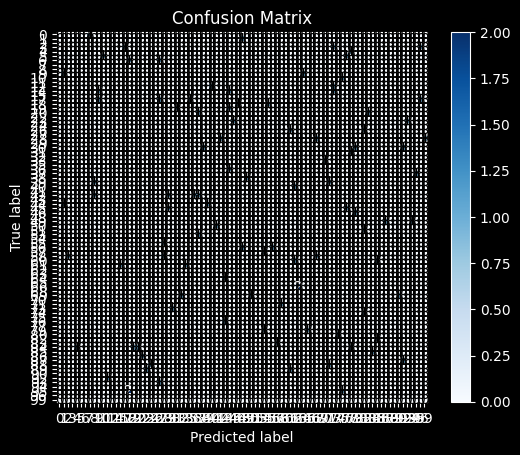

In [ ]:
# num_of_classes = 2
# num_of_classes = 3
# num_of_classes = 20
num_of_classes = 100 # TODO bug
num_of_samples = 102
# num_of_samples = 1000
y_true = torch.randint(0, num_of_classes, size=(num_of_samples,))
y_pred_logits = torch.softmax(torch.randn(num_of_samples, num_of_classes), dim=1)
figures, figure_names = draw_classification_metrics(y_true, 
                               y_pred_logits, 
                               logits_to_prob=False, 
                               labels=list(range(num_of_classes)), 
                               )

In [ ]:
[1,2,3].pop(0)
warnings.warn("This is a warning")

/tmp/ipykernel_1542695/3728250618.py:2: UserWarning: This is a warning
  warnings.warn("This is a warning")


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()